# Churn Modeling (Milestone 4)
This notebook develops predictive models to analyze churn using Logistic Regression and Random Forest.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import sklearn
import joblib
print('scikit-learn version:', sklearn.__version__)

scikit-learn version: 1.6.1


In [2]:
# Load finalized dataset
df = pd.read_csv('finalized_churn_dataset.csv')
df.head()

,customer_id,signup_date,plan_type,age,region,tenure,MonthlyCharges,TotalCharges,customer_lifetime_value,avg_order_value,ticket_count,avg_resolution_time,engagement_score,churn
0,CUST_0001,2022-04-07,Basic,49,East,52,107.73,5601.96,5601.96,107.687115,3.0,38.100000,3006.476893,0
1,CUST_0002,2022-03-08,Basic,64,West,15,45.79,686.85,686.85,46.028667,0.0,0.000000,3043.707143,0
2,CUST_0003,2020-10-17,Basic,66,East,61,86.00,5246.00,5246.00,85.409672,3.0,42.806667,2658.893500,1
3,CUST_0004,2021-12-25,Basic,28,East,21,101.72,2136.12,2136.12,103.198571,0.0,0.000000,3444.863061,0
4,CUST_0005,2020-06-13,Basic,38,East,24,75.52,1812.48,1812.48,75.191667,0.0,0.000000,2740.261316,1


In [3]:
# Features and target
X = df.drop('churn', axis=1)
y = df['churn']

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

In [4]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

if sklearn.__version__ >= '1.2':
    cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
else:
    cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', cat_transformer, cat_cols)
    ],
    remainder='drop'
)
print('Preprocessor ready')

Preprocessor ready


In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [6]:
# Logistic Regression with SMOTE
pipe_lr = ImbPipeline(steps=[('preproc', preprocessor),
                             ('smote', SMOTE(random_state=42)),
                             ('clf', LogisticRegression(max_iter=1000))])
pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))
print('ROC AUC:', roc_auc_score(y_test, pipe_lr.predict_proba(X_test)[:,1]))

              precision    recall  f1-score   support

           0       0.71      0.65      0.68        26
           1       0.75      0.79      0.77        34

    accuracy                           0.73        60
   macro avg       0.73      0.72      0.73        60
weighted avg       0.73      0.73      0.73        60

ROC AUC: 0.8178733031674208


In [7]:
# Random Forest with SMOTE + Hyperparameter tuning
pipe_rf = ImbPipeline(steps=[('preproc', preprocessor),
                             ('smote', SMOTE(random_state=42)),
                             ('clf', RandomForestClassifier(random_state=42))])

param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [5, 10]
}

grid_rf = GridSearchCV(pipe_rf, param_grid, cv=3, scoring='roc_auc')
grid_rf.fit(X_train, y_train)
y_pred_rf = grid_rf.predict(X_test)
print('Best Params:', grid_rf.best_params_)
print(classification_report(y_test, y_pred_rf))
print('ROC AUC:', roc_auc_score(y_test, grid_rf.predict_proba(X_test)[:,1]))

Best Params: {'clf__max_depth': 10, 'clf__n_estimators': 200}
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        26
           1       0.89      1.00      0.94        34

    accuracy                           0.93        60
   macro avg       0.95      0.92      0.93        60
weighted avg       0.94      0.93      0.93        60

ROC AUC: 0.9592760180995474


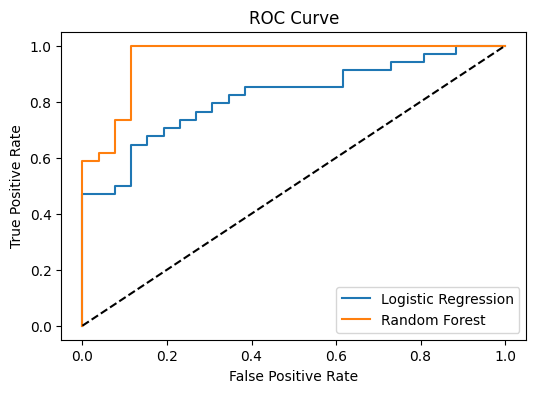

In [8]:
# ROC Curve comparison
y_pred_prob_lr = pipe_lr.predict_proba(X_test)[:,1]
y_pred_prob_rf = grid_rf.predict_proba(X_test)[:,1]

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)

plt.figure(figsize=(6,4))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

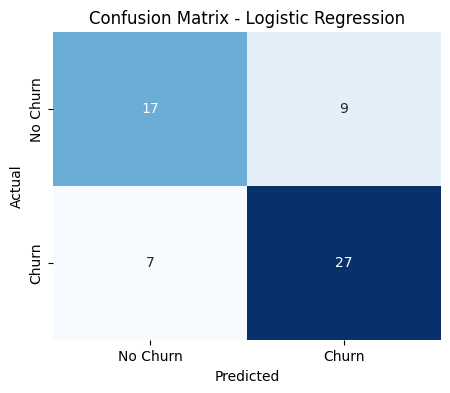

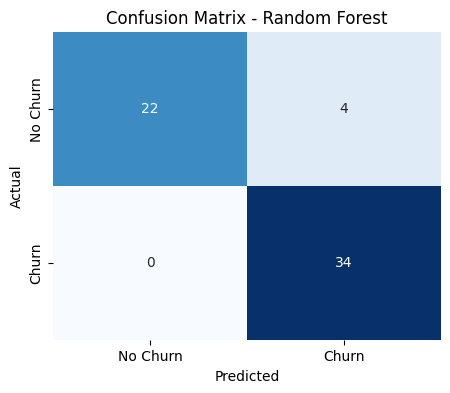

In [9]:
# Confusion Matrix Heatmaps
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["No Churn", "Churn"],
                yticklabels=["No Churn", "Churn"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

plot_conf_matrix(y_test, y_pred_lr, "Confusion Matrix - Logistic Regression")
plot_conf_matrix(y_test, y_pred_rf, "Confusion Matrix - Random Forest")

                 Model  Accuracy  Precision    Recall  F1-score   ROC-AUC
0  Logistic Regression  0.733333   0.750000  0.794118  0.771429  0.817873
1        Random Forest  0.933333   0.894737  1.000000  0.944444  0.959276


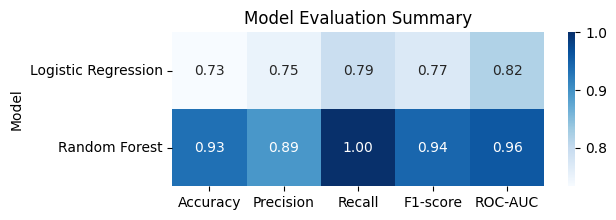

Saved model_bundle.pkl


In [10]:
# Evaluation Summary Table
def evaluate_model(name, y_true, y_pred, y_proba):
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_proba)
    }

results = []
results.append(evaluate_model("Logistic Regression", y_test, y_pred_lr, pipe_lr.predict_proba(X_test)[:,1]))
results.append(evaluate_model("Random Forest", y_test, y_pred_rf, grid_rf.predict_proba(X_test)[:,1]))

results_df = pd.DataFrame(results)
print(results_df)

plt.figure(figsize=(6,2))
sns.heatmap(results_df.set_index("Model"), annot=True, fmt=".2f", cmap="Blues")
plt.title("Model Evaluation Summary")
plt.show()


model_bundle = {
    "model": grid_rf.best_estimator_,      # trained sklearn Pipeline (preprocessor + clf)
    "features": X.columns.tolist(),  # ordered list of feature column names
    "version": "v1"
}

joblib.dump(model_bundle, "model_bundle.pkl")
print("Saved model_bundle.pkl")